In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/ETT/ETT_v3.zip /content/ETT_v3.zip
!unzip ETT_v3.zip
!mv /content/ETT_v3/ETT_v3/* /content/ETT_v3/
!rmdir /content/ETT_v3/ETT_v3


Archive:  ETT_v3.zip
   creating: ETT_v3/ETT_v3/
   creating: ETT_v3/ETT_v3/Fold1/
   creating: ETT_v3/ETT_v3/Fold1/test/
  inflating: ETT_v3/ETT_v3/Fold1/test/A_0.jpg  
  inflating: ETT_v3/ETT_v3/Fold1/test/A_0_0.jpg  
  inflating: ETT_v3/ETT_v3/Fold1/test/A_0_1.jpg  
  inflating: ETT_v3/ETT_v3/Fold1/test/A_0_10.jpg  
  inflating: ETT_v3/ETT_v3/Fold1/test/A_0_11.jpg  
  inflating: ETT_v3/ETT_v3/Fold1/test/A_0_12.jpg  
  inflating: ETT_v3/ETT_v3/Fold1/test/A_0_13.jpg  
  inflating: ETT_v3/ETT_v3/Fold1/test/A_0_15.jpg  
  inflating: ETT_v3/ETT_v3/Fold1/test/A_0_16.jpg  
  inflating: ETT_v3/ETT_v3/Fold1/test/A_0_17.jpg  
  inflating: ETT_v3/ETT_v3/Fold1/test/A_0_18.jpg  
  inflating: ETT_v3/ETT_v3/Fold1/test/A_0_2.jpg  
  inflating: ETT_v3/ETT_v3/Fold1/test/A_0_3.jpg  
  inflating: ETT_v3/ETT_v3/Fold1/test/A_0_4.jpg  
  inflating: ETT_v3/ETT_v3/Fold1/test/A_0_5.jpg  
  inflating: ETT_v3/ETT_v3/Fold1/test/A_0_6.jpg  
  inflating: ETT_v3/ETT_v3/Fold1/test/A_0_8.jpg  
  inflating: ETT_v3/ET

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from skimage import measure
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import jaccard_score
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import SeparableConv2D


In [ ]:
#physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], True)


In [ ]:
if not os.path.exists('weights'):
    os.makedirs('weights')


In [ ]:
def crop_and_resize(img, mask, size=256):
    '''
    Crop the image to square and resize to 256x256

    '''
    # crop to square
    h, w = img.shape
    # print(f'h: {h}, w: {w}')
    if h > w:
        img = img[:w, :]
        mask = mask[:w, :]
    else:
        w_center = w // 2
        img = img[:, w_center - h // 2: (w_center - h // 2)+h]
        mask = mask[:, w_center - h // 2: (w_center - h // 2)+h]

    # resize to 256x256
    img = cv2.resize(img, (size, size))
    mask = cv2.resize(mask, (size, size))

    return img, mask

def data_augmentation(img, mask):
    # CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img_c = clahe.apply(img)
    # horizontal flip
    # https://claire-chang.com/2023/06/09/%E4%BD%BF%E7%94%A8opencv%E5%B0%87%E5%9C%96%E5%BD%A2%E8%BD%89%E6%AD%A3/
    img_f = cv2.flip(img_c, flipCode=1)
    mask_f = cv2.flip(mask, flipCode=1)
    return img_c, img_f, mask_f

def img_normalize(img, mask):
    # 0~255 -> 0~1
    img = img / 255

    # 0~255 -> 0 or 1
    binary_mask = mask.copy()
    #binary_mask[mask > 128] = 1
    #binary_mask[mask <= 128] = 0
    binary_mask = mask / 255

    img = img.astype(np.float32)
    binary_mask = binary_mask.astype(np.float32)

    img = np.expand_dims(img, axis=-1)
    binary_mask = np.expand_dims(binary_mask, axis=-1)

    return img, binary_mask


In [ ]:
def load_img_from_one_folder(folder_name, sub_folder_name):
    imgs = []
    masks = []

    # img files list
    file_list = os.listdir(os.path.join('ETT_v3', folder_name, sub_folder_name))

    for file_num in range(len(file_list)):
        print(f'loading {folder_name}/{sub_folder_name}: {file_num+1}/{len(file_list)}', end='\r')

        file_name = file_list[file_num]
        img_path = os.path.join('ETT_v3', folder_name, sub_folder_name, file_name)
        mask_path = os.path.join('ETT_v3', folder_name, sub_folder_name+'annot', file_name.replace('.jpg', '.png'))

        if not (os.path.isfile(img_path)):
            # img does not exist
            print(f'file {img_path} not exist')
            continue
        elif not (os.path.isfile(mask_path)):
            # same name mask does not exist
            mask_path = mask_path.replace('img', 'mask')
            if not (os.path.isfile(mask_path)):
                # another name mask does not exist
                print(f'file {mask_path} not exist')
                continue

        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # crop and resize
        img, mask = crop_and_resize(img, mask)

        # data augmentation (CLAHE, horizontal flip)
        img, img_f, mask_f = data_augmentation(img, mask)

        # normalize
        img, mask = img_normalize(img, mask)
        img_f, mask_f = img_normalize(img_f, mask_f)

        imgs.append(img)
        masks.append(mask)
        imgs.append(img_f)
        masks.append(mask_f)

    print('')

    imgs = np.array(imgs)
    masks = np.array(masks)

    return imgs, masks


In [ ]:
# 4. 架構 U-net 模型
## 定義卷積塊
def conv_block(input_tensor, num_filters):
    x = Conv2D(num_filters, (3, 3), activation='relu', padding='same')(input_tensor)
    x = Conv2D(num_filters, (3, 3), activation='relu', padding='same')(x)
    return x

## 定義編碼器塊
def encoder_block(input_tensor, num_filters):
    x = conv_block(input_tensor, num_filters)
    p = MaxPooling2D((2, 2))(x)
    return x, p

## 定義解碼器塊
def decoder_block(input_tensor, concat_tensor, num_filters):
    x = UpSampling2D((2, 2))(input_tensor)
    x = Concatenate()([x, concat_tensor])
    x = conv_block(x, num_filters)
    return x

# 構建U-Net模型
def build_unet(input_shape):
    inputs = Input(input_shape, dtype=tf.float32)

    x1, p1 = encoder_block(inputs, 128)
    x2, p2 = encoder_block(p1, 256)
    x3, p3 = encoder_block(p2, 512)
    b = conv_block(p3, 512)  # Bridge

    d1 = decoder_block(b, x3, 512)
    d2 = decoder_block(d1, x2, 256)
    d3 = decoder_block(d2, x1, 128)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(d3)

    model = Model(inputs, outputs)
    return model


In [ ]:
PIXELS_PER_CM = 72
def iou(y_true, y_pred):
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]), tf.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    return intersection / union
# Mean error in cm
def mean_error_in_cm(y_true, y_pred, pixels_per_cm=PIXELS_PER_CM):
    # Assuming y_true and y_pred are the y-coordinates of the ETT endpoint in pixels
    absolute_difference = tf.abs(y_true - y_pred)
    mean_error = tf.reduce_mean(absolute_difference) / pixels_per_cm
    return mean_error

# Accuracy within 0.5 cm
def accuracy_within_half_cm(y_true, y_pred, pixels_per_cm=PIXELS_PER_CM):
    absolute_difference = tf.abs(y_true - y_pred)
    accuracy = tf.reduce_mean(tf.cast(absolute_difference <= (pixels_per_cm / 2), tf.float32)) * 100
    return accuracy

# Accuracy within 1.0 cm
def accuracy_within_one_cm(y_true, y_pred, pixels_per_cm=PIXELS_PER_CM):
    absolute_difference = tf.abs(y_true - y_pred)
    accuracy = tf.reduce_mean(tf.cast(absolute_difference <= pixels_per_cm, tf.float32)) * 100
    return accuracy

def find_endpoints(mask, threshold=0.5, pixels_per_cm=72):
    """
    Find the endpoints of the ETT in the predicted mask.
    """
    # Ensure the mask is 2D
    mask = np.squeeze(mask)  # Remove single-dimensional entries from the shape of an array.

    # Binarize the mask
    binary_mask = mask > threshold

    # Label connected regions of the binary mask
    labeled_mask, _ = measure.label(binary_mask, return_num=True)

    # Find contours in the binary mask
    contours = measure.find_contours(labeled_mask, level=0.5)

    endpoints = []

    # Find the endpoints for each contour
    for contour in contours:
        # Assuming the endpoint is the topmost point of the contour
        topmost = contour[contour[:, 0].argmin()]
        endpoints.append((topmost[1], topmost[0]))  # (x, y)

    # Convert pixel positions to cm based on PIXELS_PER_CM
    endpoints_in_cm = [(x / pixels_per_cm, y / pixels_per_cm) for x, y in endpoints]

    return endpoints_in_cm

def calculate_test_metrics(test_images, test_true_masks, test_pred_masks):
  iou_scores = []
  mean_errors = []
  acc_half_cm = []
  acc_one_cm = []

  for true_mask, pred_mask in zip(test_true_masks, test_pred_masks):
    endpoints_true = find_endpoints(true_mask)
    endpoints_pred = find_endpoints(pred_mask)

    # 確保只有一個端點被檢測到
    if len(endpoints_true) == 1 and len(endpoints_pred) == 1:
      true_y = endpoints_true[0][1]
      pred_y = endpoints_pred[0][1]
      iou_scores.append(iou(true_mask, pred_mask))
      mean_errors.append(mean_error_in_cm(true_y, pred_y))
      acc_half_cm.append(accuracy_within_half_cm(true_y, pred_y))
      acc_one_cm.append(accuracy_within_one_cm(true_y, pred_y))

  return {
    'iou': np.mean(iou_scores),
    'mean_error': np.mean(mean_errors),
    'accuracy_0.5cm': np.mean(acc_half_cm),
    'accuracy_1cm': np.mean(acc_one_cm)
  }

In [ ]:
class IOUCallback(Callback):
    def __init__(self, validation_data):
        super(IOUCallback, self).__init__()
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_preds = self.model.predict(self.validation_data[0])
        val_iou = iou(self.validation_data[1], val_preds)
        logs['val_iou'] = val_iou
        print(f" - val_iou: {val_iou:.4f}")

def visualize_prediction(image, true_mask, predicted_mask):
    plt.figure(figsize=(10, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title('Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(true_mask.squeeze(), cmap='gray')
    plt.title('Ground Truth Mask')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask.squeeze(), cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.show()

def binarize_mask(predicted_mask, threshold=0.5):
  return (predicted_mask > threshold).astype(np.float32)

In [ ]:
folders_list = os.listdir('ETT_v3')
one_folder_name = 'Fold1'

for folder_name in folders_list:
    # Folder 1 ~ Folder 6
    # Load data
    if folder_name == one_folder_name:
      train_imgs, train_masks = load_img_from_one_folder(folder_name, 'train')
      valid_imgs, valid_masks = load_img_from_one_folder(folder_name, 'val')
      test_imgs, test_masks = load_img_from_one_folder(folder_name, 'test')
      # create model
      model = build_unet((256, 256, 1))
      model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[iou])
      # train model
      callbacks = [
          keras.callbacks.ModelCheckpoint(os.path.join('weights', f'segnet_{folder_name}.h5'), save_best_only=True, save_weights_only=True, mode='min'),
          keras.callbacks.EarlyStopping(monitor='val_loss',patience=5, restore_best_weights=True)
      ]

      history = model.fit(
          train_imgs, train_masks,
          validation_data=(valid_imgs, valid_masks),
          epochs=100,
          batch_size=8,
          callbacks=[callbacks]
      )
      if not os.path.exists(os.path.join('weights', f'segnet_{folder_name}.h5')):
          model.save_weights(os.path.join('weights', f'segnet_{folder_name}.h5'))
      else:
          model.load_weights(os.path.join('weights', f'segnet_{folder_name}.h5'))

      test_pred_masks = model.predict(test_imgs)
      #test_pred_masks_bin = binarize_mask(test_pred_masks)
      test_metrics = calculate_test_metrics(test_imgs, test_masks, test_pred_masks)
      print(f"Performance for {folder_name}:")
      print(f"IOU: {test_metrics['iou']}")
      print(f"Mean error (cm): {test_metrics['mean_error']}")
      print(f"Accuracy within 0.5cm: {test_metrics['accuracy_0.5cm']}%")
      print(f"Accuracy within 1cm: {test_metrics['accuracy_1cm']}%")

      # 可視化測試集預測結果
      for i, (img, true_mask, pred_mask) in enumerate(zip(test_imgs, test_masks, test_pred_masks)):
          visualize_prediction(img, true_mask, pred_mask)
          #if i >= 5:  # 顯示前 5 個預測結果
              #break
      tf.keras.backend.clear_session()
    else:
        # 如果不是指定的資料夾，則跳過當前迭代
        continue
# Placeholder function for loading images and masks
def load_image_and_mask(image_path, mask_path):
    """
    Load image and its corresponding mask.
    (Placeholder function: actual implementation should load the images from the file system)
    """
    image = plt.imread(image_path)
    mask = plt.imread(mask_path)
    return image, mask

# Placeholder function for predicting mask
def predict_mask(model, image):
    """
    Predict the mask for an image using the provided model.
    (Placeholder function: actual implementation should use the model to predict the mask)
    """
    # Simulate prediction
    predicted_mask = np.random.rand(*image.shape[:2]) > 0.5
    return predicted_mask

# Visualization function
def visualize_prediction(image, true_mask, predicted_mask):
    """
    Visualize the image, the true mask, and the predicted mask side by side.
    """
    fig, ax = plt.subplots(1, 3, figsize=(8, 5))
    ax[0].imshow(image, cmap='gray')
    ax[0].set_title('Image')
    ax[0].axis('off')

    ax[1].imshow(true_mask, cmap='gray')
    ax[1].set_title('Ground Truth Mask')
    ax[1].axis('off')

    ax[2].imshow(predicted_mask, cmap='gray')
    ax[2].set_title('Predicted Mask')
    ax[2].axis('off')

    plt.show()

In [ ]:
# 創建模型
model = build_unet((256, 256, 1))

# 編譯模型
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[iou])

# 打印模型摘要
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 128)        1280      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 128)        147584    ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 128)        0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [ ]:
!pip install pydot
!apt-get install graphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


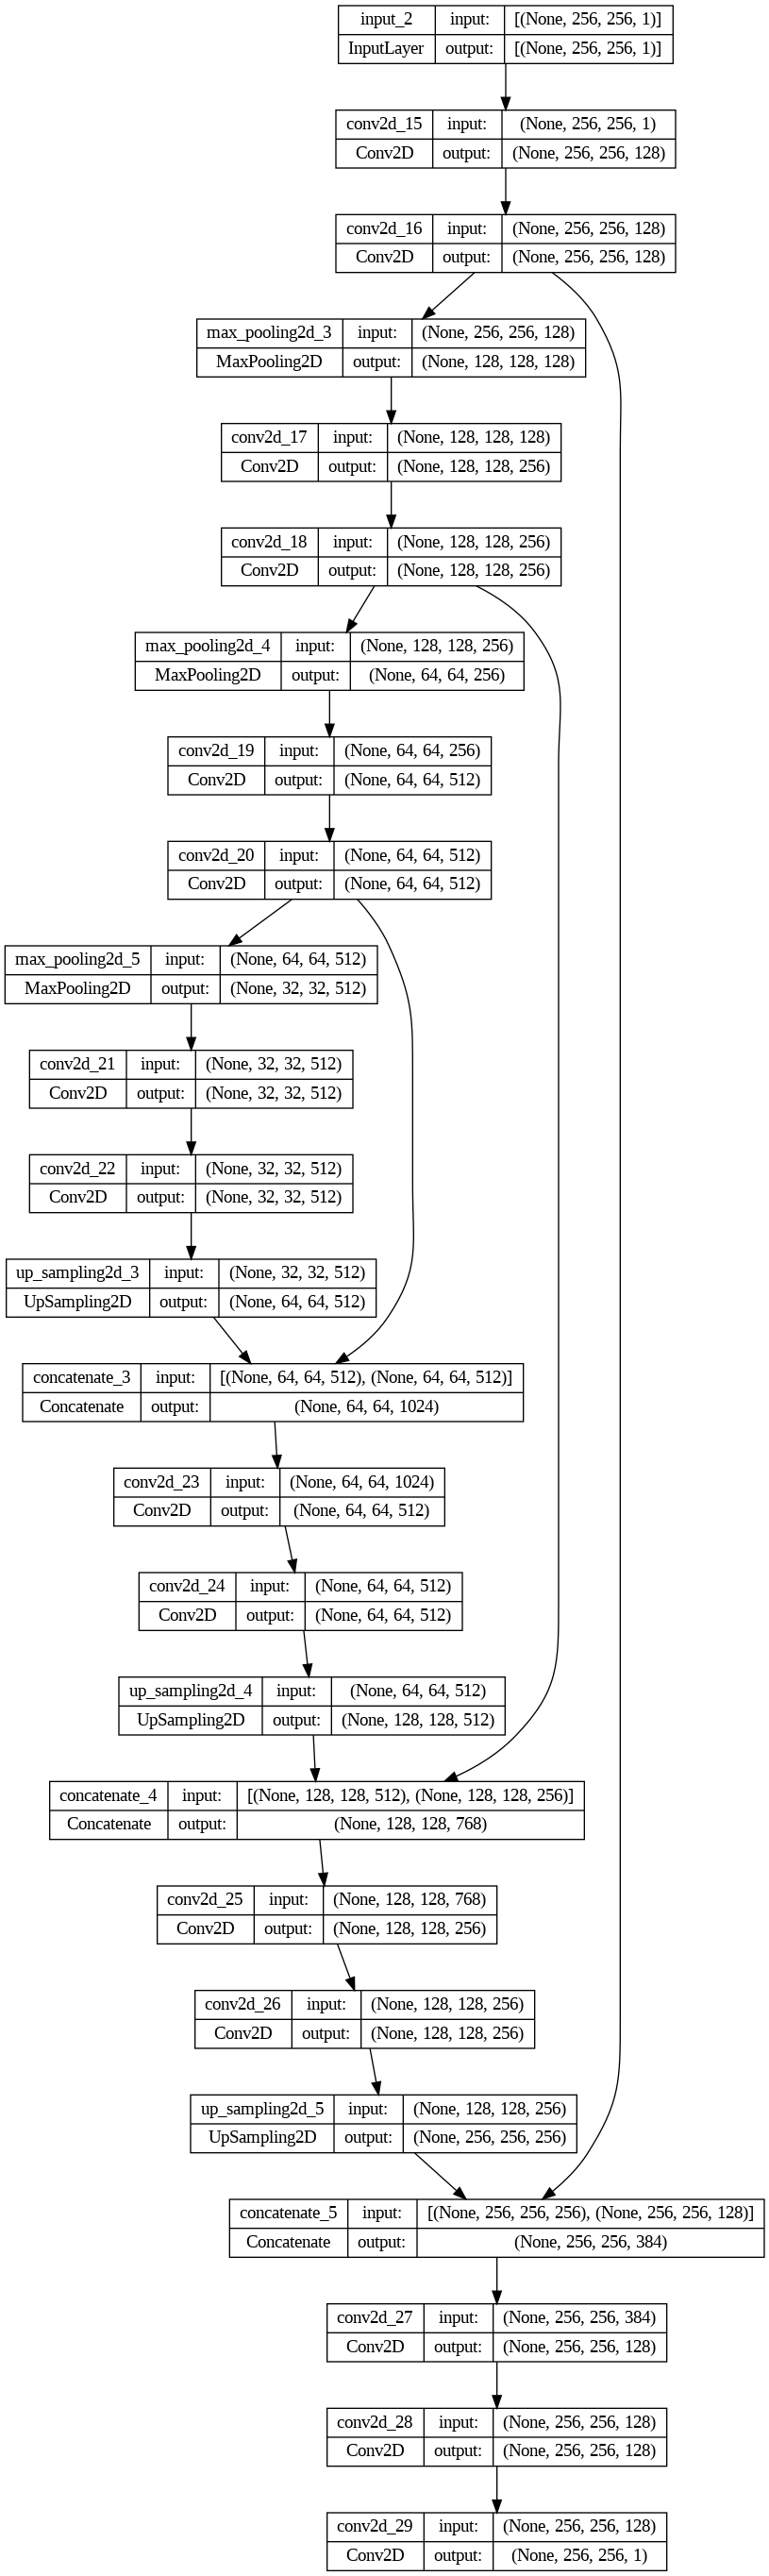

In [ ]:
from tensorflow.keras.utils import plot_model

# 創建模型
model = build_unet((256, 256, 1))

# 使用 plot_model 畫出模型架構
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

# 在 Jupyter Notebook 或 Colab 中顯示模型圖形
from IPython.display import Image
Image(filename='model.png')